# Online Learning Project
## [Paper] "A Tutorial on Conformal Prediction" by Glenn Shafer and Vladimir Vovk

In this paper, the authors present a novel method for evualuating machine learning model's accuracy in an online setting. Given a desired level $\epsilon$, the method constructs a confidence region $\Gamma^\epsilon$ for the predicted value that has at least a $1 - \epsilon$ probability of including the true value.

In this notebook we will implement the conformal prediction algorithm for both **classification** and **regression** and test it on some widely used datasets.

#### Some imports and global variables :

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from tqdm import tqdm

import pandas as pd
from scipy import stats

from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

In [4]:
np.random.seed(0)

The only hypothesis we are making hese is that the samples of the training data are exchangeable. In the particular case were the samples are assumed to be i.i.d, this is obviously verified.

## Conformal Algorithm using old examples alone

Let's generate some initial values from a binomial distribution :

In [5]:
n_trials = 5
n_samples = 10

samples = list(np.random.binomial(n=n_trials, p=1/3, size=n_samples))

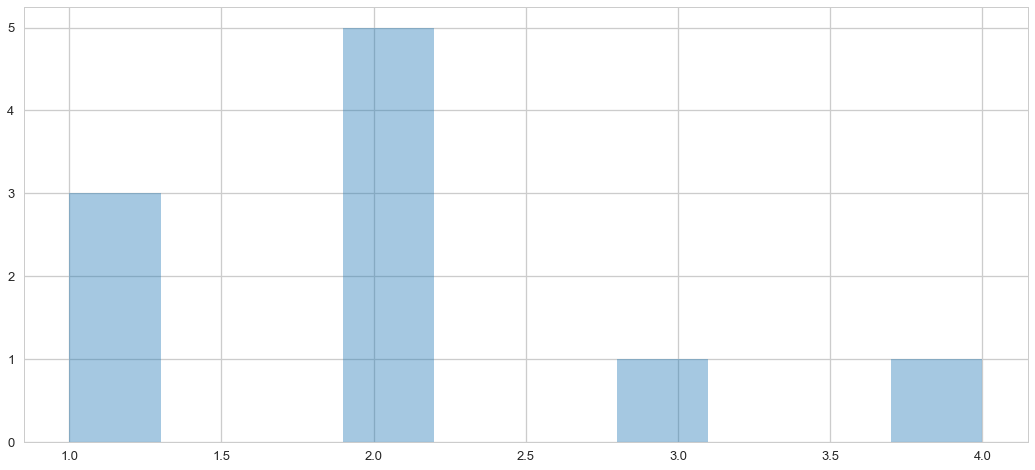

In [6]:
plt.figure(figsize=(18, 8))
sns.distplot(samples, kde=False, bins=n_samples)
plt.show()

We define a **non-conformity measure** that is simply the distance of the new value to the average of all previous values. Then we use this measure in a **conformal algorithm** that outputs an estimated conformity probability. We then compare this probability to the desired confidence **level** $\epsilon$ and keep the value if the probability is higher than $\epsilon$.

In [7]:
def nonconformity_measure(previous_values, new_value):
    estimation_from_old_examples = np.sum(previous_values) + new_value
    estimation_from_old_examples /= (len(previous_values) + 1.)
    return np.abs(estimation_from_old_examples - new_value)

def conformal_algorithm_from_old_examples(non_conformity_measure, previous_examples, new_example):
    n = len(previous_examples) + 1
    examples = list(previous_examples) + [new_example]

    alphas = []
    for i in range(n):
        alphas.append(non_conformity_measure(examples[:i] + examples[i+1:], examples[i]))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p

Given previous values the possible value of the next one is in $\{0, 1, 2, 3, 4, 5\}$.

In [8]:
possible_values = range(n_trials + 1)

We choose and $\epsilon$ value of 0.05 :

In [9]:
epsilon = 0.05

Let's test the conformal algorithm on 100 new values :

In [10]:
def get_confidence_region(nonconformity_measure, samples, possible_values, epsilon):
    confidence_region = []
    for value in possible_values:
        p = conformal_algorithm_from_old_examples(nonconformity_measure, samples, value)
        if p > epsilon:
            confidence_region.append(value)
    return confidence_region

In [11]:
hits = []
region_sizes = []
for _ in tqdm(range(200)):
    confidence_region = get_confidence_region(nonconformity_measure, samples, possible_values, epsilon)
    new_value = np.random.binomial(n=n_trials, p=1/3)
    hits.append(new_value in confidence_region)
    region_sizes.append(len(confidence_region))
    samples += [new_value]

100%|██████████| 200/200 [00:07<00:00, 28.30it/s]


In [12]:
print(f"Hit frequency : {np.mean(hits)}")

Hit frequency : 0.995


In [13]:
print(f"Average confidence region size : {np.mean(region_sizes)}")

Average confidence region size : 4.99


Whenever a new value is indeed in the constructed confidence region, we say that it is a 'hit'. We can see here that the hit frequency is higher than 1-$\epsilon$ = 0.95, and therefore the confidence regions seem **valid**. On the other hand, the average confidence region size is $\approx$ 5 which shows that the algorithm almost never rejects a value. 

In [14]:
epsilon = 0.05

confidence_region = get_confidence_region(nonconformity_measure, samples, possible_values, epsilon)
starting_len = len(confidence_region)
        
while len(confidence_region) == starting_len:
    epsilon += 0.01
    confidence_region = get_confidence_region(nonconformity_measure, samples, possible_values, epsilon)

In [15]:
print(epsilon)

0.19000000000000003


By reducing the value of $\epsilon$ until rejecting a value from the interval, we see that the required level for a tighter confidence region is almost 20%.

## Conformal Algorithm using a new object
### Classification - Iris Dataset

Now let's see how to use conformal prediction in a more classical machine learning problem : the classification of the Iris Dataset

In [16]:
X, y = load_iris(return_X_y=True)
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [17]:
def nonconformity_measure(bag_features, bag_targets, features, target):

    # Compute distances to :
    closest_same_category = min([np.linalg.norm(features - x, ord=2)
                                 for x, y in zip(bag_features, bag_targets) if y==target])
    closest_different_category = min([np.linalg.norm(features - x, ord=2)
                                      for x, y in zip(bag_features, bag_targets) if y!=target])
    
    measure = closest_same_category / closest_different_category
    return measure

def conformal_algorithm_using_new_object(nonconformity_measure, bag_features, bag_targets, features, value):
    n = len(bag_features) + 1
    
    X = list(bag_features) + [features]
    y = list(bag_targets) + [value]

    alphas = []
    for i in range(n):
        alphas.append(nonconformity_measure(
            X[:i] + X[i+1:], y[:i] + y[i+1:], X[i], y[i]
        ))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p

The possible categories are $\{0, 1, 2\}$.

In [18]:
possible_categories = set(y)

We choose and $\epsilon$ value of 0.05 :

In [19]:
epsilon = 0.05

Let's test the conformal algorithm :

In [20]:
def get_confidence_region(nonconformity_measure, bag_features, bag_targets, features, possible_categories):
    confidence_region = []
    for c in possible_categories:
        score = conformal_algorithm_using_new_object(
            nonconformity_measure, bag_features, bag_targets, features, c)
        if score > epsilon:
            confidence_region.append(c)
    return confidence_region

In [21]:
hits = []
region_sizes = []
hits_model = []
for i in tqdm(range(20, len(X))):
    confidence_region = get_confidence_region(nonconformity_measure, X[:i], y[:i], X[i], possible_categories)
    hits.append(y[i] in confidence_region)
    region_sizes.append(len(confidence_region))

    model = RandomForestClassifier()
    model.fit(X[:i], y[:i])
    y_predicted = model.predict([X[i]])[0]
    hits_model.append(y_predicted in confidence_region)

100%|██████████| 130/130 [00:33<00:00,  3.89it/s]


In [22]:
np.mean(hits)

0.9384615384615385

First of all, we can see that the hit frequency is $\approx$ 1-$\epsilon$. So this is a good thing, the confidence regions seem to be valid.

In [23]:
np.mean(region_sizes)

0.9692307692307692

This time, by computing the average region size we get a values almost equal to 1. This is an ideal scenario as we would always want to have one and only one value in the confidence region so that we can predict this value.

In [24]:
np.mean(hits_model)

0.9230769230769231

By computing the hit frequency of a random forest classifier that trains on previous data and tries to predict the new target at each iteration, we get a slightly higher value. This is probably due to a sub-optimal choice of non-conformity metric. (Sometimes the classifier doesn't predict a value in the confidence region, and this values happens to be true)

### Regression - Diabetes Dataset

In [25]:
X, y = load_diabetes(return_X_y=True)
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

The algorithm is the same, we only need to define a proper non-conformity measure :

In [26]:
def nonconformity_measure(bag_features, bag_targets, features, target):
    model = GradientBoostingRegressor()
    model.fit(bag_features, bag_targets)
    y_predicted = model.predict([features])[0]
    return np.abs(target - y_predicted)

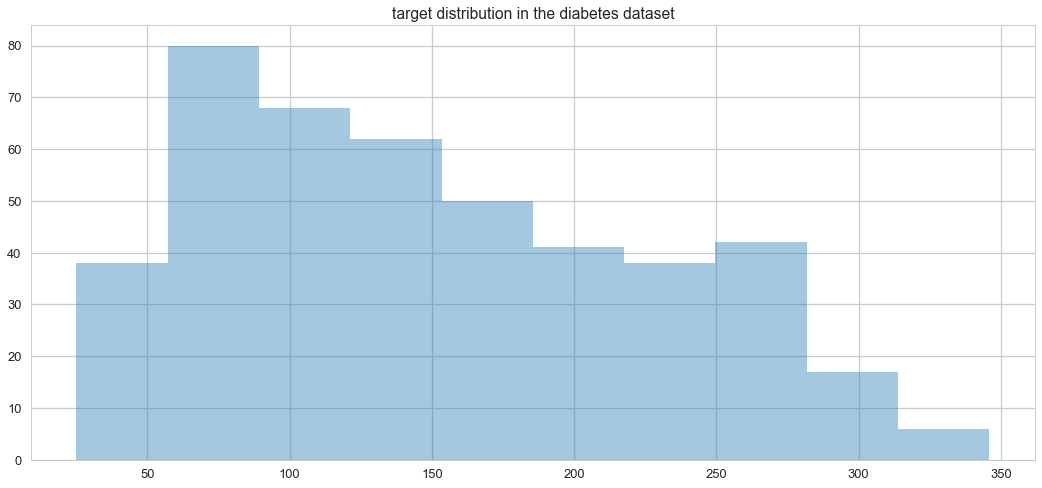

In [27]:
plt.figure(figsize=(18, 8))
plt.title("target distribution in the diabetes dataset")
sns.distplot(y, kde=False)
plt.show()

The values seem distributed between 0 and 350 so :

In [28]:
possible_values = np.linspace(0, 350, 10)

We choose and $\epsilon$ value of 0.05 :

In [29]:
epsilon = 0.05

Let's test the conformal algorithm :

In [30]:
def get_confidence_region(nonconformity_measure, bag_features, bag_targets, features, possible_values):
    confidence_region = []
    for v in possible_values:
        score = conformal_algorithm_using_new_object(
            nonconformity_measure, bag_features, bag_targets, features, v)
        if score > epsilon:
            confidence_region.append(v)
    return confidence_region

In [31]:
hits = []
region_sizes = []
for i in tqdm(range(20, 100)):
    confidence_region = get_confidence_region(nonconformity_measure, X[:i], y[:i], X[i], possible_values)
    hits.append((y[i] > min(confidence_region)) & (y[i] < max(confidence_region)))
    region_sizes.append(len(confidence_region))

100%|██████████| 80/80 [44:38<00:00, 33.48s/it]


In [32]:
np.mean(hits)

0.875

As we can see, the hit frequency is a bit lower than the expected 95%, but this is probably due to the fact that we discretize the space of possible values.

In [33]:
np.mean(region_sizes)/len(possible_values)

0.605

The ratio average_region_size / maximum_possible_size is around 60%, which is not that bad. Just to have an idea, if we were constructing a 95% confidence interval of random normal values,  the width of the interval would have been 4$\sigma$, for a 99.7% CI the width would have been 6$\sigma$. The later CI has almost all of the distribution in it so we could say it is the maximum possible size. The ratio is then $\frac{4}{6}\approx$ 66%.